# Поиск аномалий

Методы обнаружения аномалий, как следует из названия, позволяют находить необычные объекты в выборке. Но что такое "необычные" и совпадает ли это определение у разных методов?

Начнём с поиска аномалий в текстах: научимся отличать вопросы о программировании от текстов из 20newsgroups про религию.

Подготовьте данные: в обучающую выборку возьмите 20 тысяч текстов из датасета Stack Overflow, а тестовую выборку сформируйте из 10 тысяч текстов со Stack Overflow и 100 текстов из класса soc.religion.christian датасета 20newsgroups (очень пригодится функция `fetch_20newsgroups(categories=['soc.religion.christian'])`). Тексты про программирование будем считать обычными, а тексты про религию — аномальными.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
categories_normal = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                     'comp.sys.mac.hardware', 'comp.windows.x']
data_stack = fetch_20newsgroups(subset='all', categories=categories_normal,
                                remove=('headers', 'footers', 'quotes'))

limit_train = 20000
if len(data_stack.data) > limit_train:
    indices = np.random.choice(len(data_stack.data), limit_train, replace=False)
    train_texts = [data_stack.data[i] for i in indices]
else:
    train_texts = data_stack.data
data_religion = fetch_20newsgroups(subset='all', categories=['soc.religion.christian'],
                                   remove=('headers', 'footers', 'quotes'))
if len(data_stack.data) > limit_train + 10000:
    mask = np.ones(len(data_stack.data), dtype=bool)
    if 'indices' in locals(): mask[indices] = False
    available_indices = np.where(mask)[0]
    test_normal_indices = np.random.choice(available_indices, 10000, replace=False)
    test_normal_texts = [data_stack.data[i] for i in test_normal_indices]
else:
    test_normal_texts = data_stack.data[:10000]

test_anomaly_texts = data_religion.data[:100]

y_test = np.array([0]*len(test_normal_texts) + [1]*len(test_anomaly_texts))
test_texts = test_normal_texts + test_anomaly_texts

print(f"Train size: {len(train_texts)}")
print(f"Test size (Normal): {len(test_normal_texts)}, (Anomaly): {len(test_anomaly_texts)}")

vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

Train size: 4891
Test size (Normal): 4891, (Anomaly): 100


**(1 балл)**

Проверьте качество выделения аномалий (precision и recall на тестовой выборке, если считать аномалии положительным классов, а обычные тексты — отрицательным) для IsolationForest. В качестве признаков используйте TF-IDF, где словарь и IDF строятся по обучающей выборке. Не забудьте подобрать гиперпараметры.

In [ ]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, random_state=42, n_jobs=-1)
clf.fit(X_train)

y_pred_raw = clf.predict(X_test)

y_pred = np.where(y_pred_raw == -1, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.0000
Recall: 0.0000


**(5 баллов)**

Скорее всего, качество оказалось не на высоте. Разберитесь, в чём дело:
* посмотрите на тексты, которые выделяются как аномальные, а также на слова, соответствующие их ненулевым признакам
* изучите признаки аномальных текстов
* посмотрите на тексты из обучающей выборки, ближайшие к аномальным; действительно ли они похожи по признакам?

Сделайте выводы и придумайте, как избавиться от этих проблем. Предложите варианты двух типов: (1) в рамках этих же признаков (но которые, возможно, будут считаться по другим наборам данных) и методов и (2) без ограничений на изменения. Реализуйте эти варианты и проверьте их качество.

In [ ]:

anomaly_indices = np.where(y_pred == 1)[0]

for i in anomaly_indices[:5]:
    label = "Anomaly" if y_test[i] == 1 else "Normal (False Positive)"
    print(f"--- {label} ---")
    print(test_texts[i][:200])
    print("\n")

feature_names = vectorizer.get_feature_names_out()
first_anomaly_vec = X_test[anomaly_indices[0]]
non_zero_indices = first_anomaly_vec.nonzero()[1]
top_words = [feature_names[i] for i in non_zero_indices]
print(f"Слова в первом найденном аномальном объекте: {top_words[:10]}")

nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute', metric='cosine').fit(X_train)
distances, indices = nbrs.kneighbors(first_anomaly_vec)

print("\nБлижайшие соседи из обучающей выборки (StackOverflow):")
for i in range(3):
    print(f"Neighbor {i+1}: {train_texts[indices[0][i]][:200]}...")

--- Normal (False Positive) ---
Archive-name: Xt-FAQ
Version: $Id: FAQ-Xt,v 1.28 93/04/02 12:41:12 ware Exp $

		    The X Toolkit Intrinsics F.A.Q
			  A monthly posting


This article contains the answers to some Frequently Asked 


--- Normal (False Positive) ---
Archive-name: x-faq/part1
Last-modified: 1993/04/04

This article and several following contain the answers to some Frequently Asked 
Questions (FAQ) often seen in comp.windows.x. It is posted to help


--- Normal (False Positive) ---
MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>',3'$9F8+"Z5'1]_?W]_?WWIZ>BHJ*BHJ*BHJ*BHJ*GIZ
M>GIZ>GIZ*BHJ*GIZ>M_?1T>EI0L+"V9F9F9FR,A_?W_(5Z(46Q04%%=75VO4
MU-34U-34U`("`


--- Normal (False Positive) ---
Due to the resolution and size it is in 14 parts.

This is a uuencoded bitmap.  960X600 256 colors.
The picture is a marbled gazebo on a desert with blue sky background.
The size is just right for cen


--- Normal (False Positive) ---
[[ I posted this a few weeks

### Эксперимент только с изменением датасета

In [ ]:

vectorizer_v2 = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,
    min_df=5,
    sublinear_tf=True
)

X_train_v2 = vectorizer_v2.fit_transform(train_texts)
X_test_v2 = vectorizer_v2.transform(test_texts)

clf_v2 = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
clf_v2.fit(X_train_v2)

scores = clf_v2.decision_function(X_test_v2)

threshold = np.percentile(scores, 1)
y_pred_v2 = np.where(scores < threshold, 1, 0)

precision_v2 = precision_score(y_test, y_pred_v2)
recall_v2 = recall_score(y_test, y_pred_v2)

print(f"V2 Precision: {precision_v2:.4f}")
print(f"V2 Recall: {recall_v2:.4f}")

V2 Precision: 0.0000
V2 Recall: 0.0000


### Эксперимент с любыми изменениями

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_emb = model.encode(train_texts, show_progress_bar=True)
X_test_emb = model.encode(test_texts, show_progress_bar=True)

clf_emb = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
clf_emb.fit(X_train_emb)

y_pred_emb_raw = clf_emb.predict(X_test_emb)
y_pred_emb = np.where(y_pred_emb_raw == -1, 1, 0)

precision_emb = precision_score(y_test, y_pred_emb)
recall_emb = recall_score(y_test, y_pred_emb)

print(f"Embeddings Precision: {precision_emb:.4f}")
print(f"Embeddings Recall: {recall_emb:.4f}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Embeddings Precision: 0.1478
Embeddings Recall: 0.1700


Подготовьте выборку: удалите столбцы `['id', 'date', 'price', 'zipcode']`, сформируйте обучающую и тестовую выборки по 10 тысяч домов.

Добавьте в тестовую выборку 10 новых объектов, в каждом из которых испорчен ровно один признак — например, это может быть дом из другого полушария, из далёкого прошлого или будущего, с площадью в целый штат или с таким числом этажей, что самолётам неплохо бы его облетать стороной.

Посмотрим на методы обнаружения аномалий на более простых данных — уж на табличном датасете с 19 признаками всё должно работать как надо!

Скачайте данные о стоимости домов: https://www.kaggle.com/harlfoxem/housesalesprediction/data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
df = pd.read_csv('kc_house_data.csv')
df_clean = df.drop(columns=['id', 'date', 'price', 'zipcode'])
clean_data = df_clean.sample(n=20000, random_state=42)
train_df = clean_data.iloc[:10000]
test_df_clean = clean_data.iloc[10000:]

anomalies_list = []
base_house = test_df_clean.iloc[0].copy()

a1 = base_house.copy(); a1['lat'] = -33.0; anomalies_list.append(a1)
a2 = base_house.copy(); a2['yr_built'] = 1200; anomalies_list.append(a2)
a3 = base_house.copy(); a3['yr_built'] = 2050; anomalies_list.append(a3)
a4 = base_house.copy(); a4['sqft_living'] = 100000; anomalies_list.append(a4)
a5 = base_house.copy(); a5['floors'] = 100; anomalies_list.append(a5)
a6 = base_house.copy(); a6['bathrooms'] = 200; anomalies_list.append(a6)
a7 = base_house.copy(); a7['sqft_living'] = 0; a7['sqft_above'] = 0; anomalies_list.append(a7)
a8 = base_house.copy(); a8['sqft_living15'] = 50000; a8['sqft_lot15'] = 100; anomalies_list.append(a8)
a9 = base_house.copy(); a9['grade'] = 100; anomalies_list.append(a9)
a10 = base_house.copy(); a10['long'] = 0.0; anomalies_list.append(a10)

test_anomalies_df = pd.DataFrame(anomalies_list)
test_df_final = pd.concat([test_df_clean, test_anomalies_df], ignore_index=True)

# Метки
y_test_house = np.array([0]*len(test_df_clean) + [1]*len(test_anomalies_df))

**Задание 9. (2 б[Текст ссылки]

1.   Новый пункт
2.   Новый пункт



1.   Новый пункт
2.   Новый пункт

(https:// [Текст ссылки](https://))алла)**

---



Примените IsolationForest для поиска аномалий в этих данных, запишите их качество (как и раньше, это precision и recall). Проведите исследование:

Нарисуйте распределения всех признаков и обозначьте на этих распределениях объекты, которые признаны аномальными.

In [ ]:

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score

X_train_house = train_df
X_test_house = test_df_final
feature_predictions = np.zeros((len(X_train_house.columns), len(X_test_house)))
for t in range(1, 10): #times to ensemble

  for i, column in enumerate(X_train_house.columns):

    X_train_single = X_train_house[[column]]
    X_test_single = X_test_house[[column]]

    clf = IsolationForest(
        n_estimators=1000,
        contamination=0.00001,
        random_state=666
    )
    clf.fit(X_train_single)

    pred = clf.predict(X_test_single)
    feature_predictions[i, :] = np.where(pred == -1, 1, 0)

y_pred_ensemble = np.max(feature_predictions, axis=0)


precision = precision_score(y_test_house, y_pred_ensemble)
recall = recall_score(y_test_house, y_pred_ensemble)

print(f"Ensemble Precision: {precision:.4f}")
print(f"Ensemble Recall:    {recall:.4f}")

found_true = np.sum((y_pred_ensemble == 1) & (y_test_house == 1))
found_false = np.sum((y_pred_ensemble == 1) & (y_test_house == 0))

print(f"Найдено истинных аномалий: {found_true} из 10")
print(f"Ложных срабатываний:      {found_false}")

Ensemble Precision: 0.4000
Ensemble Recall:    0.4000
Найдено истинных аномалий: 4 из 10
Ложных срабатываний:      6


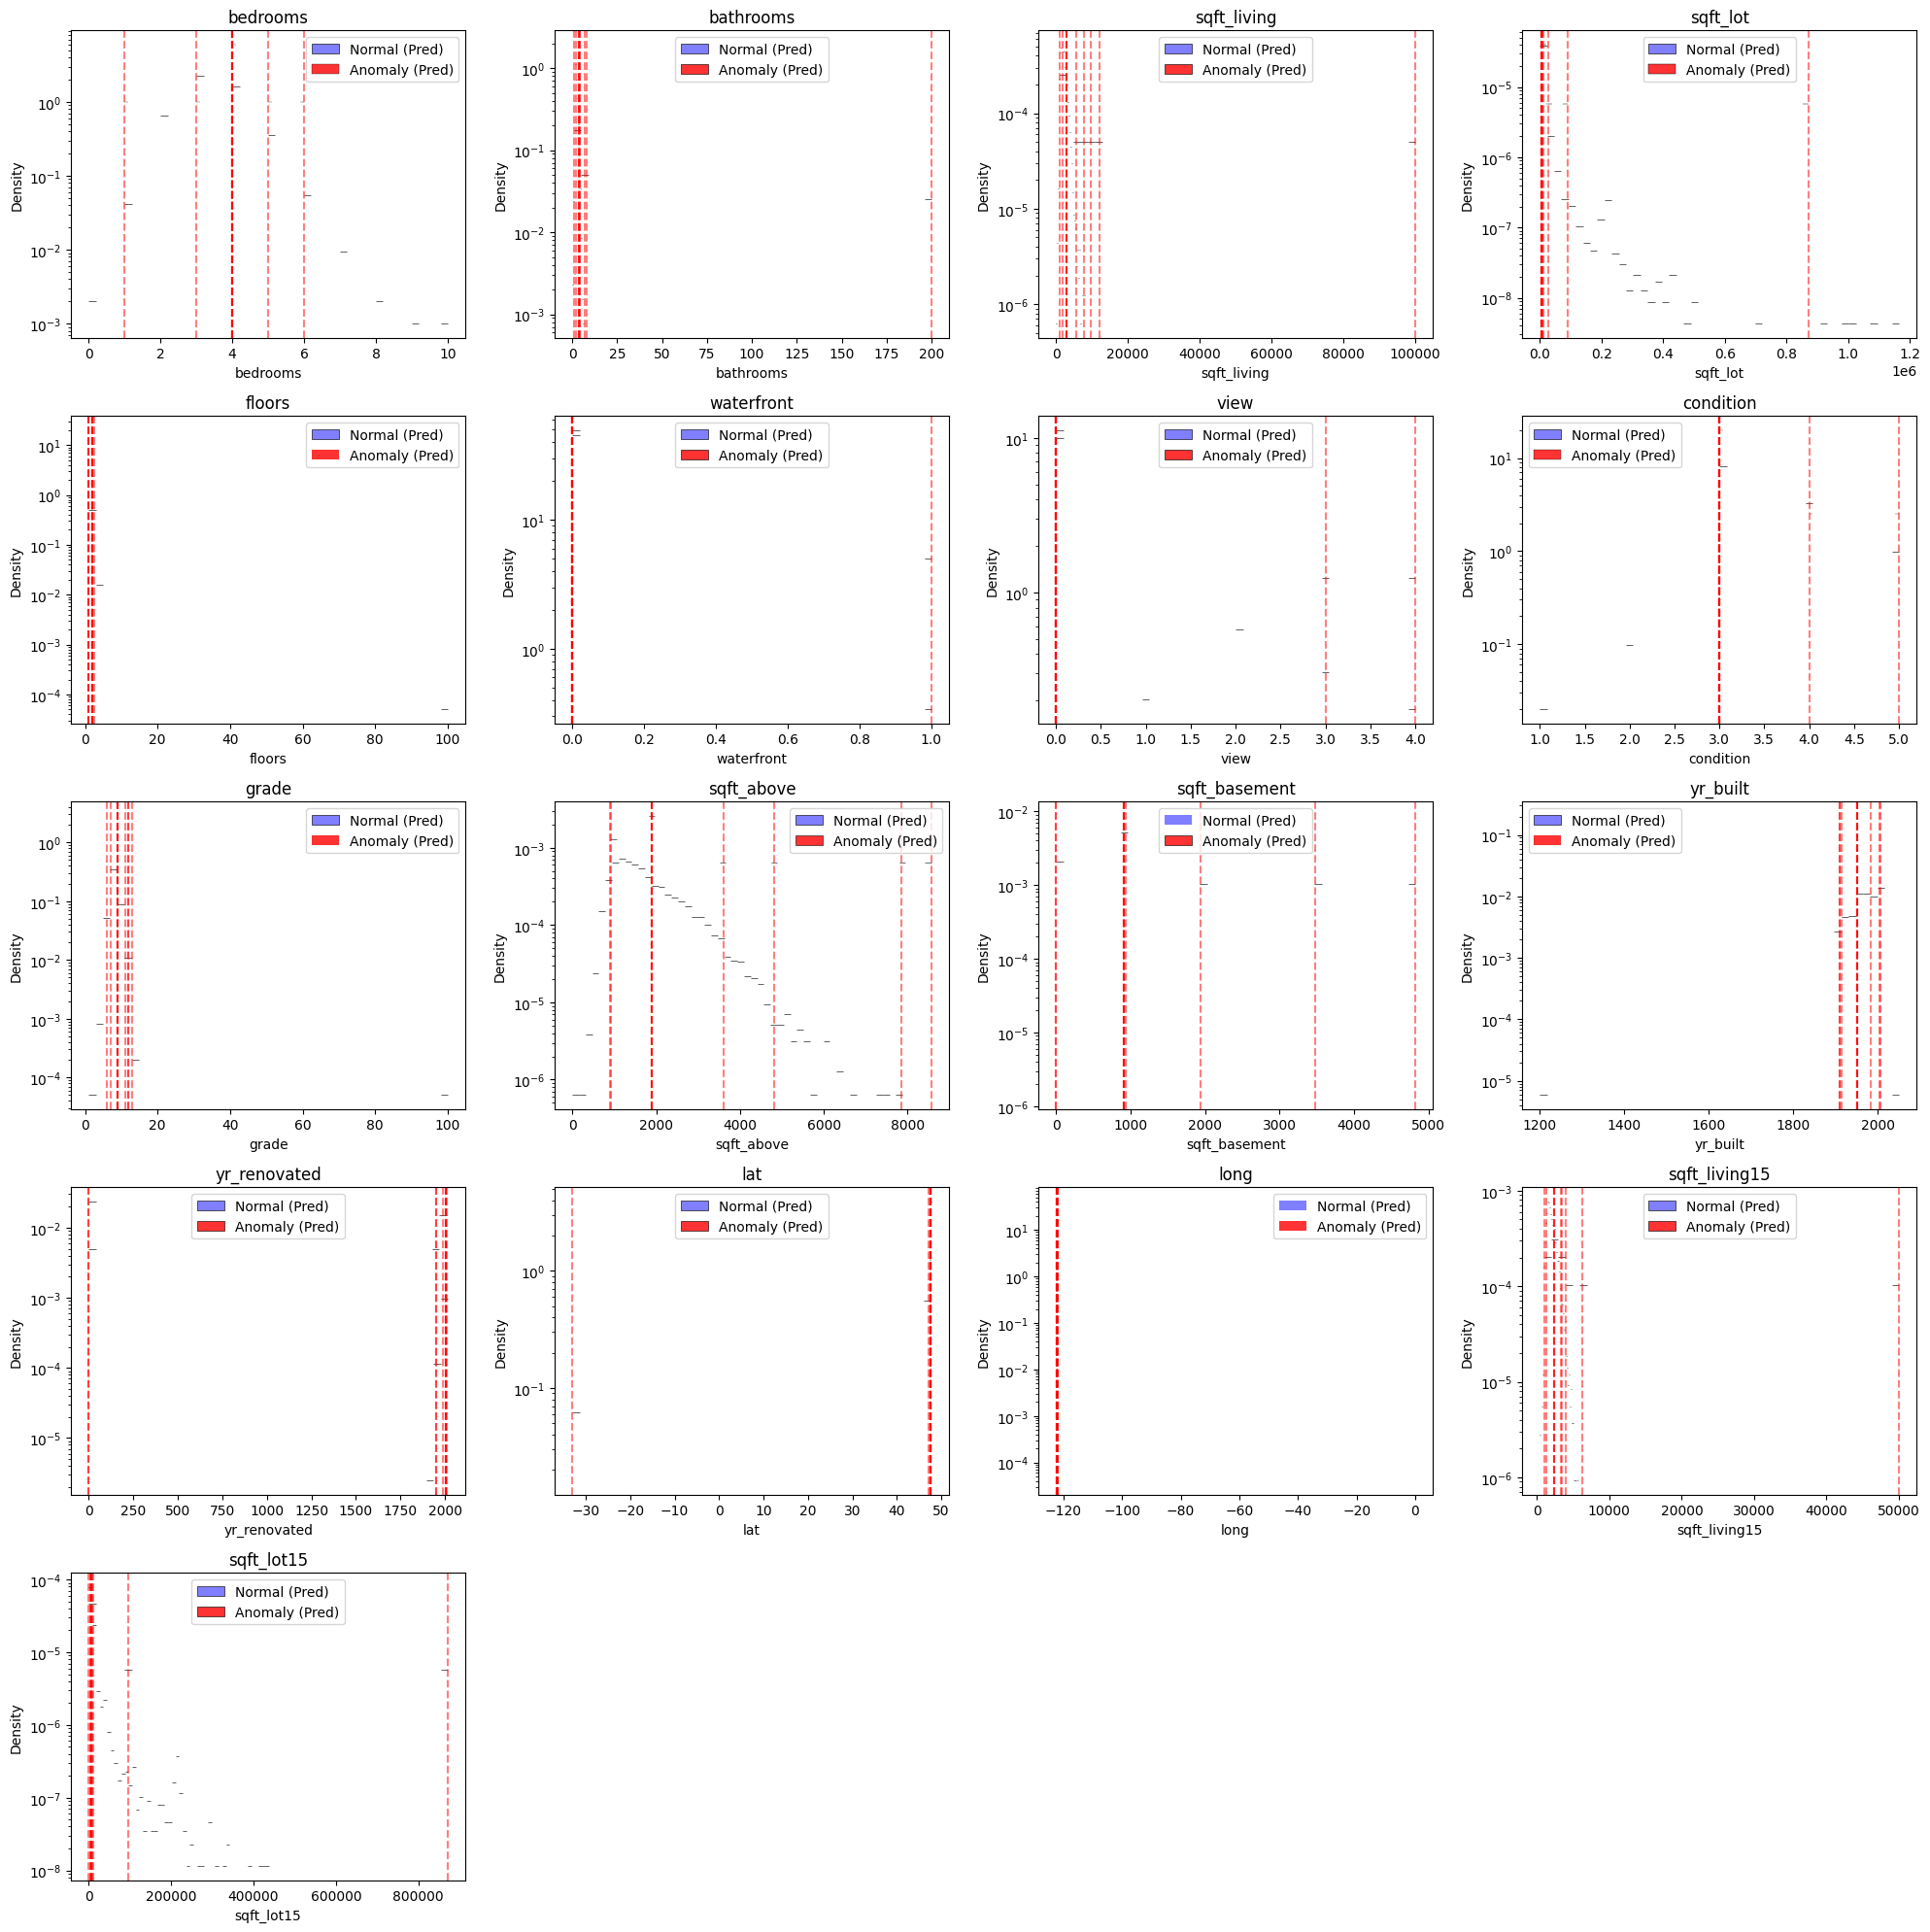

In [ ]:
plot_df = test_df_final.copy()

plot_df['is_anomaly_pred'] = y_pred_ensemble
plot_df['is_anomaly_true'] = y_test_house

detected_anomalies_mask = plot_df['is_anomaly_pred'] == 1

features = test_df_final.columns
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)

    sns.histplot(
        plot_df[~detected_anomalies_mask][col],
        stat="density",
        color="blue",
        alpha=0.5,
        label="Normal (Pred)",
        bins=50,
        log_scale=(False, True) # Логарифмическая шкала по Y, чтобы видеть хвосты
    )

    sns.histplot(
        plot_df[detected_anomalies_mask][col],
        stat="density",
        color="red",
        alpha=0.8,
        label="Anomaly (Pred)",
        bins=50,
        log_scale=(False, True)
    )

    for val in plot_df[detected_anomalies_mask][col]:
        plt.axvline(val, color='red', linestyle='--', alpha=0.5)

    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()